In [64]:
#Librerias.
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
import os 
import sys

#### Variables Y Constantes Globales.

In [65]:
# Variables Y Constantes Globales.
SCALE_FACTOR = (4500000)/24/(2**23-1) #From the pyOpenBCI. 
Ca=1                                  #Canal.
fs=250                                #Frecuencia de muestreo 250 Hz.
lowcut = 0.1                          #Banda Baja para el filtro.
highcut =20                           #Banda Alta para el filtro.
win = 512 * fs                        #Ventana para realizar el psd.

#### Funciones.

In [66]:
def Signal(file,RC):
    channel=(np.loadtxt(file,delimiter=',',skiprows=200,usecols=[RC]))* SCALE_FACTOR#Lectura Del Canal De La Señal EEG. 
    return channel      
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)                        #Coeficientes Filtro Butterworth
    y = lfilter(b, a, data)                                                         #Filtro IIR
    return y                                                            
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq                                                              #Banda Baja Para Pasa-Bandas
    high = highcut / nyq                                                            #Banda Alta Para Pasa-Bandas
    b, a = butter(order, [low, high], btype='band')                                 #Numerador (b) y denominador (a) polinomios del filtro IIR.
    return b, a
def notch_filter(val, data, fs=250):
        notch_freq_Hz = np.array([float(val)])                                      #Filtro Notch Frecuencia
        for freq_Hz in np.nditer(notch_freq_Hz):                                    
            bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])                          #Asignación de Banda (57>= 60 <=63)Hz
            b, a = signal.butter(3, bp_stop_Hz / (fs / 2.0), 'bandstop')            #Numerador (b) y denominador (a) polinomios del filtro IIR.
            fin = data = signal.lfilter(b, a, data)                                 #Filtro IIR
        return fin
def Argumentos(freqs, psd, rangoLow, rangoHigh):
    freqs=(freqs[freqs < rangoHigh])                                                #Acotar El Vector De Frecuencia.
    freqs_=np.where(((freqs > rangoLow) & (freqs < rangoHigh)))                     #Acotar Aun Rango La Frecuencia.
    indI=freqs_[0][0]                                                               #Valor Inferior Del Rango.
    indS=freqs_[0][-1]                                                              #Valor Superior Del Rango.
    Argumentos=psd[indI:indS]                                                       #Amplitudes PSD En Relación Al Rango.
    freqs=freqs[indI:indS]                                                          #Rango Frecuencial.
    ArgMax=np.where(max(Argumentos) == Argumentos)                                  #Calculo Del Maximo En Amplitud Del Rango.
    Ejex=freqs[ArgMax[0][0]]                                                        #Frecuencia
    Arguments=[Ejex]                                                                #
    ArgMax=Argumentos[ArgMax[0][0]]                                                 #Valor Maximo En Amplitud PSD.
    Arguments.append(ArgMax)                                                        
    return Arguments

#### Carga De Dataset.

In [67]:
mainpath= "D:Data"                 #Directorio del Archivo.
filename= "4h3.txt"                        #Nombre Del Archivo.
fullpath =os.path.join(mainpath, filename) #Unión De Ubicación.
Canal=Signal(fullpath,Ca)                   
Sample= len(Canal) + 200                   #Muestras.
Canal=Canal[0:Sample]                      #Longitud Del Canal.
print(Sample)               

2495


#### Filtros Para Limpiar La Señal Y Quitar El Componente De La Red.

In [68]:
Canal_NF = notch_filter(60, Canal)                                          #Filtro Notch.
Canal_NF_BP = butter_bandpass_filter(Canal_NF, lowcut, highcut, fs, order=2)#Filtro Pasa-Banda.

#### Procesamiento De La Señal Mediante La funcion Welch (PSD).
* Funcion para hallar el máximo de un determinado rango . 

In [69]:
freqs, psd = signal.welch(Canal_NF_BP, fs, nperseg=win)                 #Función Para Estimar La Densidad Espectral De Potencia Welch.
ArgRang4hz= Argumentos(freqs, psd, 3.85, 4.15)                          #Argumentos Maximo En Amplitud y Frecuencia Para Cada SSVEP.
ArgRang5hz= Argumentos(freqs, psd, 4.85, 5.15)                          #""         ""          ""         ""   
ArgRang6hz= Argumentos(freqs, psd, 5.85, 6.15)                          #""         ""          ""         ""   
ArgRang7hz= Argumentos(freqs, psd, 6.85, 7.15)                          #""         ""          ""         ""   
ArgRangall=[ArgRang4hz[1], ArgRang5hz[1], ArgRang6hz[1], ArgRang7hz[1]] #Agrupación De Maximos En Amplitud De Cada Frecuencia SSVEP.
Arguments = ArgRang4hz + ArgRang5hz + ArgRang6hz + ArgRang7hz           #Agrupación De Rangos Amplitud y Frecuencia.
Auxmax=np.where(max(ArgRangall) == ArgRangall)                          #Calculo Del Maximo De Todas Las Frecuencias SSVEP.
ValorY=ArgRangall[Auxmax[0][0]]                                         
ValorX=np.where(Arguments == ValorY)                                    #Frecuencia Relacionada A la Amplitud Maxima.
ValorX=Arguments[(ValorX[0][0])-1]                                      
f=open("data_experience.txt","a")                                       #Escritura En Archivo Plano Amplitud y Frecuencia.
f.write(str(ValorX) +","+ str(ValorY) +","+ filename[0:2] + "z \n")     
f.close()                                                               

#### Plot De La Señal.

Text(0.5, 1.0, 'Canal 5 Señal De 4h3.txt')

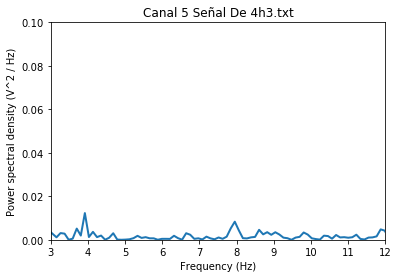

In [70]:
freqs, psd = signal.welch(Canal_NF_BP, fs, nperseg=win) #Visualización de la estimación Densidad Espectral de Potencia.
Xbl=3
Xbh=12
plt.figure(1)
plt.plot(freqs, psd, lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel("Power spectral density (V^2 / Hz)")
plt.ylim([0, 0.1])
plt.xlim([Xbl, Xbh])
plt.title("Canal 5 Señal De "+filename)